In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import helpers.utils as utils
import helpers.metrics as metrics
from helpers.constants import TREATMENT_LABEL, CONTROL_LABEL
import helpers.structured as structured

In [ ]:
users_df, events_df, tasks_df, suggestions_df = utils.final_data_prep()
print(f"Number of participants: {len(users_df)}")

# To ensure that the order of countries is consistent across plots
countries = sorted(tasks_df['country'].unique())
groups = [CONTROL_LABEL, TREATMENT_LABEL]

In [4]:
# Insert task details into the suggestions dataframe for easier analysis
dft = suggestions_df.merge(tasks_df.reset_index(), right_on=['id', 'user_id'], left_on=['task_id', 'user_id'], how='left')

# For accepted suggestions, check if the suggestion was modified
dft['modified'] = np.nan
dft['modified'] = dft.apply(lambda x: x['suggestionText'] not in x['finalHtml_stripped'] if x['is_accepted'] else np.nan, axis=1)

### Descriptive Statistics

In [3]:
# At what stage of the task was the suggestion accepted/rejected?
dft['duration_percentage'] = (dft['time_acc/rej'] - dft['time_started']) / (dft['time_completed'] - dft['time_started']) * 100

# divide task into 3 stages
dft['task_stage'] = dft['duration_percentage'].apply(lambda x: 'early' if x < 33.33 else ('middle' if x < 66.66 else 'late'))

# Compute the duration before a suggestion was accepted/rejected
dft['duration_before_acc/rej'] = dft['time_acc/rej'] - dft['time_shown']

In [4]:
print("Acceptance percentage", len(dft[dft['is_accepted'] == True])/len(dft))
print("Modification percentage", len(dft[dft['modified'] == True])/len(dft[dft['is_accepted'] == True]))

Acceptance percentage 0.12284644194756554
Modification percentage 0.21002710027100271


In [55]:
# Duration percentiles
time_before_acceptance = (dft[dft['is_accepted'] == True]['duration_before_acc/rej'] / 1000)
print(time_before_acceptance.quantile([0.25, 0.5, 0.75, 0.90]))

time_before_rejection = (dft[dft['is_accepted'] == False]['duration_before_acc/rej'] / 1000)
print(time_before_rejection.quantile([0.25, 0.5, 0.75, 0.90]))

# Percentage of suggestions accepted within 500 ms
print(len(time_before_rejection[time_before_rejection < 0.5]) / len(time_before_rejection))

0.25    1.17800
0.50    1.86950
0.75    2.90025
0.90    4.43550
Name: duration_before_acc/rej, dtype: float64
0.25    0.1420
0.50    0.2570
0.75    0.6965
0.90    2.1062
Name: duration_before_acc/rej, dtype: float64
0.6883005977796754


In [5]:
# In which stage is a user more likely to accept suggestions? (overall)
dft[dft['is_accepted'] == True].groupby('task_stage').size() / dft.groupby('task_stage').size()

task_stage
early     0.091896
late      0.158581
middle    0.120694
dtype: float64

In [6]:
# In which stage is a user more likely to accept suggestions? -- Country wise
dft[dft['is_accepted'] == True].groupby(['country', 'task_stage']).size() / dft.groupby(['country', 'task_stage']).size()

country  task_stage
IND      early         0.129660
         late          0.206692
         middle        0.159733
US       early         0.061438
         late          0.113579
         middle        0.084291
dtype: float64

In [75]:
# Explicitly rejected suggestions
(len(dft[dft['rejection_reason'] == 'pressed_escape']) / len(dft[dft['is_accepted'] == False])) * 100

0.6641996394344815

In [68]:
# I forgot what this is doing
x = (dft[dft['modified'] == True].groupby('user_id').size() / dft[dft['is_accepted']].groupby('user_id').size()).to_frame(name='perc').merge(users_df[['country']], left_index=True, right_on='user_id')
x[x['perc']>0].groupby('country').size() / x.groupby('country').size()

country
IND    0.916667
US     0.892857
dtype: float64

### Top n-grams in the suggestions (to show Western-centric suggestions)

In [6]:
def find_ngrams_in_suggestions(suggestions: list[str], n):
    # Function to find all ngrams in a list of suggestions
    ngrams = []
    for s in suggestions:
        ngrams.extend(utils.find_ngrams(s.lower(), n))
    return ngrams

In [125]:
unigrams = dft.groupby(['task_id'])['suggestionText'].apply(lambda x: find_ngrams_in_suggestions(x, 1)).to_frame(name='unigrams')
bigrams = dft.groupby(['task_id'])['suggestionText'].apply(lambda x: find_ngrams_in_suggestions(x, 2)).to_frame(name='bigrams')
trigrams = dft.groupby(['task_id'])['suggestionText'].apply(lambda x: find_ngrams_in_suggestions(x, 3)).to_frame(name='trigrams')
ngrams_df = unigrams.join(bigrams).join(trigrams)

In [130]:
for col in ngrams_df.columns:
    ngrams_df[f'top_{col}'] = ngrams_df[col].apply(lambda x: pd.Series(x).value_counts().head(5).index.tolist())

In [133]:
import json
print(json.dumps(ngrams_df['top_trigrams'].to_dict(), indent=1))

{
 "festival": [
  "is christmas because",
  "festival is christmas",
  "family and friends",
  "and friends .",
  "because of the"
 ],
 "food": [
  "is pizza because",
  "food is pizza",
  "favorite food is",
  "is sushi because",
  "and delicious ."
 ],
 "leave": [
  "a two-week leave",
  "you well .",
  "finds you well",
  "request a two-week",
  ". thank you"
 ],
 "public_figure": [
  "because of his",
  "favorite celebrity is",
  "my favorite celebrity",
  "known for his",
  "inspire others ."
 ]
}


### In the modified suggestions, what strings were left out?

While interesting, I didn't put this analysis in the paper because our method of finding the removed part of the suggestion relies on longest common subsequence, which is imperfect. Ideally, we should have tracked boundaries of the suggestions or diffs made by the user...but oh well.

In [10]:
def find_removed_parts_of_suggestion(suggestion, essay):
    still_in_essay = metrics.get_longest_part_of_suggestion_in_final_essay(suggestion, essay)
    removed = suggestion.replace(still_in_essay, '')
    return removed

dft['modified_substring'] = dft.apply(lambda x: find_removed_parts_of_suggestion(x['suggestionText'], x['finalHtml_stripped']) if x['modified'] == True else np.nan, axis=1)

In [118]:
top_removed_words_ind = dft[(dft.modified == True) & (dft.country == 'IND')].apply(lambda x: utils.find_ngrams(x['modified_substring'], 1), axis=1).explode().value_counts().to_dict()
top_removed_words_us = dft[(dft.modified == True) & (dft.country == 'US')].apply(lambda x: utils.find_ngrams(x['modified_substring'], 1), axis=1).explode().value_counts().to_dict()

# Remove punctuation and stopwords from the top removed words
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

top_removed_words_ind = {k: v for k, v in top_removed_words_ind.items() if k not in stop_words and k not in punctuation}
top_removed_words_us = {k: v for k, v in top_removed_words_us.items() if k not in stop_words and k not in punctuation}

In [119]:
top_removed_words_us

{'family': 4,
 'inspiring': 3,
 'festival': 3,
 'due': 3,
 'career': 2,
 'thank': 2,
 'special': 2,
 'gatherings': 2,
 'focused': 2,
 'pizza': 2,
 'celebrate': 2,
 'well': 2,
 'favorite': 2,
 'textures': 1,
 'impact': 1,
 'heartfeltances': 1,
 'messages': 1,
 'meaningful': 1,
 'listeners': 1,
 'many': 1,
 'resonating': 1,
 'malone': 1,
 'lyrics': 1,
 'christmas': 1,
 'matter': 1,
 'current': 1,
 'unity': 1,
 'prioritize': 1,
 'barbecues': 1,
 'eloquence': 1,
 'much': 1,
 'versatile': 1,
 'projects': 1,
 'situation': 1,
 'barrino': 1,
 'request': 1,
 'leave': 1,
 'approve': 1,
 'ease': 1,
 'celebrity': 1,
 'understanding': 1,
 'care': 1,
 'take': 1,
 'traditions': 1,
 'warmth': 1,
 'unmatched': 1,
 'creativity': 1,
 'butresilience': 1,
 'heart': 1,
 'thankful': 1,
 'day': 1,
 'meetm': 1,
 'helps': 1,
 'always': 1,
 'snacks': 1,
 'salty': 1,
 'appropriatel': 1,
 'personal': 1,
 'reasons': 1,
 'laughter': 1,
 'issuesfully': 1,
 'resolve': 1,
 'finds': 1,
 'email': 1,
 "it'n": 1,
 'hope': 

In [120]:
top_removed_words_ind

{'christmas': 8,
 'thank': 6,
 'name': 5,
 'due': 4,
 'sushi': 4,
 'leave': 4,
 'celebrate': 3,
 'two': 3,
 'weeks': 3,
 'emergency': 3,
 'family': 3,
 'pizza': 3,
 'also': 3,
 'understanding': 3,
 'boss': 2,
 'need': 2,
 'time': 2,
 'week': 2,
 'cake': 2,
 'writing': 2,
 'best': 2,
 'regards': 2,
 'reeves': 2,
 'keanu': 2,
 'enjoy': 2,
 'hank': 1,
 'lights': 1,
 'iconic': 1,
 'thefireworks': 1,
 'range': 1,
 'spreading': 1,
 'happiness': 1,
 'dance': 1,
 'festivalgood': 1,
 'lp': 1,
 'li': 1,
 'parentthis': 1,
 'theis': 1,
 'rich': 1,
 'nutrients': 1,
 'fame': 1,
 'remarkable': 1,
 'evil': 1,
 'getable': 1,
 'youunderstanding': 1,
 'ating': 1,
 'attention': 1,
 'xyz': 1,
 'request': 1,
 'two-week': 1,
 'av': 1,
 'consumed': 1,
 '14': 1,
 'years': 1,
 'exile': 1,
 'bananas': 1,
 'rose': 1,
 'temple': 1,
 'personal': 1,
 'stir-': 1,
 'reasons': 1,
 'flavor': 1,
 'special': 1,
 'most.provide': 1,
 'celebrity': 1,
 'recipes': 1,
 'addition': 1,
 'visit': 1,
 'increase': 1,
 'ed': 1,
 'mod

In [99]:
dft[dft.modified == True]

,suggestionText,leadingText,currentHtml,time_shown,time_acc/rej,is_accepted,rejection_reason,task_id,user_id,index,...,accepted,ignored,rejected,group,country,ttr,acceptance_rate,embedding,modified,modified_substring
47,iconic roles are truly memorable.,I admire Shah Rukh Khan for his incredible act...,I admire Shah Rukh Khan for his incredible act...,1722561208053,1.722561e+12,True,,public_figure,p-6632f19311dacff691b822a0,1,...,5,18.0,0.0,AI,IND,0.779661,0.217391,"[-0.009362888522446156, 0.016814984381198883, ...",True,iconic roles are
74,ookies with my family.,Christmas is my favorite holiday because it co...,Christmas is my favorite holiday because it co...,1722561341492,1.722561e+12,True,,festival,p-6632f19311dacff691b822a0,2,...,5,32.0,1.0,AI,IND,0.609375,0.131579,"[0.007108926307410002, 0.020835652947425842, -...",True,ooki
89,"[Boss's Name], I am writing to",Dear,"Dear&nbsp;<span class=""suggestion text-slate-4...",1722561419409,1.722561e+12,True,,leave,p-6632f19311dacff691b822a0,3,...,8,16.0,1.0,AI,IND,0.687500,0.32,"[-0.006300024688243866, 0.018164537847042084, ...",True,[Boss's Name]
91,upcoming surgery and recovery period.,"Dear Meena, I am writing torequest a two-week ...","Dear Meena, I am writing torequest a two-week ...",1722561453435,1.722561e+12,True,,leave,p-6632f19311dacff691b822a0,3,...,8,16.0,1.0,AI,IND,0.687500,0.32,"[-0.006300024688243866, 0.018164537847042084, ...",True,surgery and recovery period.
108,during my absence. Thank you for your understa...,"Dear Meena, I am writing torequest a two-week ...","Dear Meena, I am writing torequest a two-week ...",1722561537470,1.722562e+12,True,,leave,p-6632f19311dacff691b822a0,3,...,8,16.0,1.0,AI,IND,0.687500,0.32,"[-0.006300024688243866, 0.018164537847042084, ...",True,Thank you for your understanding.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,also carve jack-o'-lanterns together.,My favorite holiday is Halloween because I lov...,My favorite holiday is Halloween because I lov...,1723180895664,1.723181e+12,True,,festival,p-5f24b0fc546c5a0c3c2e43b6,458,...,7,34.0,0.0,AI,US,0.750000,0.170732,"[-0.012647656723856926, -0.027365999296307564,...",True,.
12001,father is very ill and requires my attention.,I need to take a two-week leave because of a ...,I need to take a two-week leave because of a ...,1723180941235,1.723181e+12,True,,leave,p-5f24b0fc546c5a0c3c2e43b6,459,...,9,9.0,0.0,AI,US,0.724138,0.5,"[0.008434236980974674, 0.015925515443086624, -...",True,.
12002,ease approve my leave request. Thank you.,I need to take a two-week leave because of a ...,I need to take a two-week leave because of a ...,1723180944307,1.723181e+12,True,,leave,p-5f24b0fc546c5a0c3c2e43b6,459,...,9,9.0,0.0,AI,US,0.724138,0.5,"[0.008434236980974674, 0.015925515443086624, -...",True,ease approve my leave request.
12007,I appreciate your understanding.,I need to take a two-week leave because of a ...,I need to take a two-week leave because of a ...,1723180969804,1.723181e+12,True,,leave,p-5f24b0fc546c5a0c3c2e43b6,459,...,9,9.0,0.0,AI,US,0.724138,0.5,"[0.008434236980974674, 0.015925515443086624, -...",True,.


In [93]:
print(dft[dft.modified == True].iloc[0]['suggestionText'])
print(dft[dft.modified == True].iloc[0]['finalHtml_stripped'])

iconic roles are truly memorable.
I admire Shah Rukh Khan for his incredible acting skills. He is a simple and humble person. he is also very witty and charming during interviews. i have watched all his films and enjoy his performances every time. His most iconic role includes Raj in Dilwale Dulaniya Le Jayenge, which is truly memorable.


### Find which artifacts was chosen by the user and which was first recommended

In [ ]:
## Tried to do this using the OpenAI API but it doesn't work to well, so I'm going to just do it manually
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

from openai import OpenAI
client = OpenAI()

# Filter data for the specific task
filtered_data = dft[(dft['country'] == 'IND') & (dft['task_id'] == 'public_figure')]

# Group by finalHtml_stripped and aggregate suggestions
grouped_data = filtered_data.groupby(['user_id', 'finalHtml_stripped']).aggregate({'suggestionText': lambda x: x.tolist()})

# Iterate over the grouped data and make API calls
for index, suggestions_shown in grouped_data.head(10).iterrows():
    user_id = index[0]
    final_essay = index[1]
    filename = f'data/fav_vs_recommended/{user_id}_public_figure.json'

    if os.path.exists(filename):
        continue

    result = structured.get_celebrity_info(client, final_essay, suggestions_shown['suggestionText'])
    # Save results to a JSON file
    with open(filename, 'w') as f:
        f.write(result)

In [14]:
task_id = 'festival'
country = 'IND'

# Filter data for the specific task
filtered_data = dft[(dft['country'] == country) & (dft['task_id'] == task_id)]
dfe = filtered_data.groupby(['user_id', 'finalHtml_stripped']).aggregate({'suggestionText': lambda x: x.tolist()}).reset_index()
dfe.to_clipboard()

In [20]:
dft[(dft.user_id == 'p-665e9abd1c2f04b05d05b04a') & (dft.task_id == 'festival')].head(30)

,suggestionText,leadingText,currentHtml,time_shown,time_acc/rej,is_accepted,rejection_reason,task_id,user_id,index,...,shown,accepted,ignored,rejected,group,country,ttr,acceptance_rate,embedding,modified
4323,My favorite festival is Christmas because,,"<span class=""suggestion text-slate-400"" conten...",1722918813719,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4324,y favorite festival is Christmas because,M,"M<span class=""suggestion text-slate-400"" conte...",1722918816310,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4325,favorite festival is Christmas because,My,"My<span class=""suggestion text-slate-400"" cont...",1722918816477,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4326,favorite festival is Christmas because,My,"My&nbsp;<span class=""suggestion text-slate-400...",1722918816610,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4327,avorite festival is Christmas because,My f,"My f<span class=""suggestion text-slate-400"" co...",1722918816860,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4328,vorite festival is Christmas because,My fa,"My fa<span class=""suggestion text-slate-400"" c...",1722918817043,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4329,orite festival is Christmas because,My fav,"My fav<span class=""suggestion text-slate-400"" ...",1722918817343,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4330,Christmas because of the joyful atmosphere.,My favorite festival is,"My favorite festival is&nbsp;<span class=""sugg...",1722918826440,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4331,with great enthusiasm and devotion.,"My favorite festival is Ganesh Chaturthi, it i...","My favorite festival is Ganesh Chaturthi, it i...",1722918842271,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN
4332,remover of obstacles.,"My favorite festival is Ganesh Chaturthi, it i...","My favorite festival is Ganesh Chaturthi, it i...",1722918844577,1.722919e+12,False,implicit,festival,p-665e9abd1c2f04b05d05b04a,194,...,51.0,1,50.0,0.0,AI,IND,0.597701,0.019608,"[-0.006036319769918919, -0.014001772738993168,...",NaN


### Analysis with Suggestion data (didn't work -- so did not end up going in the paper)

In [199]:
""" Within each writing task, when were the suggestions accepted (as percentage of task progress) """

dft = suggestions_df[suggestions_df['is_accepted'] == True].merge(tasks_df.reset_index(), right_on=['id', 'user_id'], left_on=['task_id', 'user_id'], how='left')
dft = dft[['id', 'user_id', 'time_started', 'time_completed', 'time_acc/rej', 'country', 'leadingText', 'charLength', 'finalHtml_stripped']]
dft['duration_percentage'] = (dft['time_acc/rej'] - dft['time_started']) / (dft['time_completed'] - dft['time_started']) * 100
dft['charsWritten'] = dft['leadingText'].str.len()
dft['charsPercentage'] = (dft['charsWritten'] / dft['charLength']) * 100

# Remove outliers (tasks in which too few or too many suggestions were accepted)
# dft = dft[(dft.groupby(['user_id', 'id']).transform('size') >= 3)]

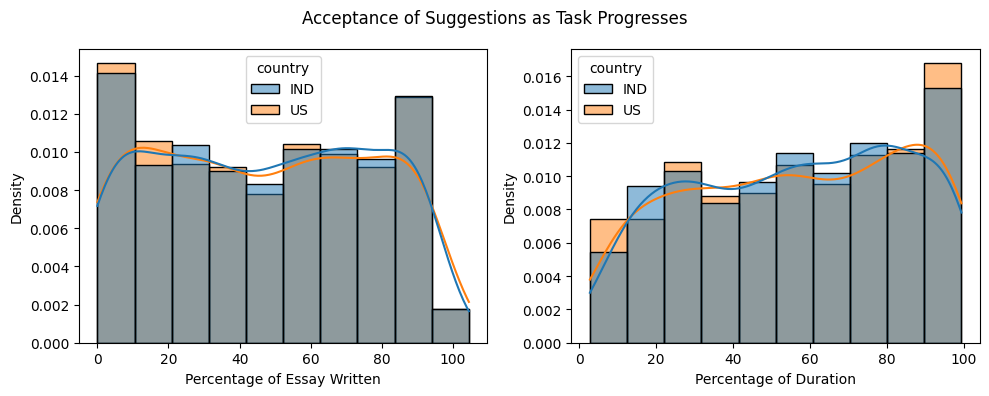

In [200]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.histplot(data=dft, x='charsPercentage', hue='country', kde=True, stat='density', common_norm=False, bins=10, ax=axs[0])
axs[0].set_xlabel('Percentage of Essay Written')

sns.histplot(data=dft, x='duration_percentage', hue='country', kde=True, stat='density', common_norm=False, bins=10, ax=axs[1])
axs[1].set_xlabel('Percentage of Duration')

plt.suptitle('Acceptance of Suggestions as Task Progresses')
plt.tight_layout()

In [201]:
df_sorted = dft.sort_values(by=['user_id', 'id', 'time_acc/rej'])
df_sorted['suggestion_number'] = df_sorted.groupby(['user_id', 'id']).cumcount() + 1
df_sorted['total_suggestions'] = df_sorted.groupby(['user_id', 'id'])['suggestion_number'].transform('max')
df_sorted['suggestion_percentage'] = (df_sorted['suggestion_number'] / df_sorted['total_suggestions']) * 100

Text(0, 0.5, 'Percentile of Suggestions Accepted')

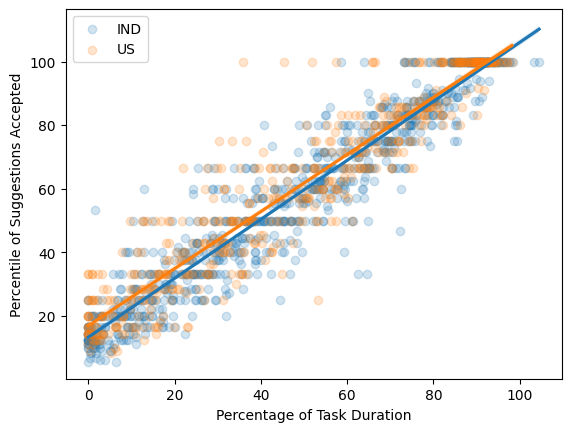

In [202]:
dft = df_sorted[df_sorted['total_suggestions'] > 2]

# also plot a line of best fit
sns.regplot(data=dft[dft['country'] == 'IND'], x='charsPercentage', y='suggestion_percentage', scatter=True, label='IND', scatter_kws={'alpha':0.2})
sns.regplot(data=dft[dft['country'] == 'US'], x='charsPercentage', y='suggestion_percentage', scatter=True, label='US', scatter_kws={'alpha':0.2})
plt.legend()
plt.xlabel('Percentage of Task Duration')
plt.ylabel('Percentile of Suggestions Accepted')

In [203]:
# For each task, compute the number of chars written (len of leadingText) before the first suggestion was accepted
# Then compute if Indians on average write more chars before accepting the first suggestion than Americans
res = df_sorted[df_sorted['suggestion_number'] == 1].groupby('country')['duration_percentage'].agg(lambda x: list(x))
ind_chars = res['IND']
us_chars = res['US']
print(stats.shapiro(ind_chars))
print(stats.shapiro(us_chars))

ShapiroResult(statistic=0.8812580745639709, pvalue=2.524542562661808e-09)
ShapiroResult(statistic=0.8829942118205174, pvalue=1.4068157819478808e-07)


In [204]:
stats.mannwhitneyu(ind_chars, us_chars)

MannwhitneyuResult(statistic=7548.0, pvalue=0.9428709836170958)